In [143]:
import numpy as np
import matplotlib.pyplot as plt

In [144]:
path = '/Users/nickhattrup/Documents/research/projects/MDPilot/examples/lennardjones/dump.lammpstrj'

In [145]:
'''
ITEM: TIMESTEP
653
ITEM: NUMBER OF ATOMS
2500
ITEM: BOX BOUNDS pp pp pp
-1.0000000000000000e+01 1.0000000000000000e+01
-1.0000000000000000e+01 1.0000000000000000e+01
-1.0000000000000000e+01 1.0000000000000000e+01
ITEM: ATOMS id vx vy vz
'''

'\nITEM: TIMESTEP\n653\nITEM: NUMBER OF ATOMS\n2500\nITEM: BOX BOUNDS pp pp pp\n-1.0000000000000000e+01 1.0000000000000000e+01\n-1.0000000000000000e+01 1.0000000000000000e+01\n-1.0000000000000000e+01 1.0000000000000000e+01\nITEM: ATOMS id vx vy vz\n'

In [146]:
num_lines = sum(1 for _ in open(path))

with open(path, 'r') as f:
    heading = 0
    while True:
        line = f.readline()
        if 'ITEM: NUMBER OF ATOMS' in line:
            n_atoms = int(f.readline())
            heading +=2
        elif 'ITEM: ATOMS id vx vy vz' in line:
            heading += 1
            break
        else:
            heading += 1
    

In [147]:
samples = num_lines // (n_atoms + heading)

In [148]:
velocities = np.zeros((samples, n_atoms, 1))

In [149]:
with open(path, 'r') as f:
    for i in range(samples):
        for j in range(heading):
            f.readline()
        for j in range(n_atoms):
            idx, vx, vy, vz = f.readline().split()
            velocities[i, int(idx)-1, 0] = np.sqrt(float(vx)**2 + float(vy)**2 + float(vz)**2)
      
    


In [150]:
velocities.shape

(250, 2500, 1)

In [151]:
bins = np.linspace(0, 4, 50)

# Compute histograms for each sample and collect bin counts
histograms = np.array([np.histogram(velocities[i], bins=bins, density=True)[0] for i in range(velocities.shape[0])])

# Average the histograms (average bin counts)
#average_histogram = np.mean(histograms, axis=0)

In [152]:
# Cumulative average of the histograms
cumulative_average_histogram = np.cumsum(histograms, axis=0) / np.arange(1, histograms.shape[0] + 1)[:, None]

In [153]:
cumulative_average_histogram.shape

(250, 49)

In [154]:
v = np.linspace(0, 4, 100)
v_dist = (1/(2*np.pi))**(3/2) * 4*np.pi*v**2 * np.exp(-v**2/2)

In [159]:
# Get probability density associated with each bin from v_dist 
bin_widths = np.diff(bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
v_dist_at_bins = (1/(2*np.pi))**(3/2) * 4*np.pi*bin_centers**2 * np.exp(-bin_centers**2/2)
v_dist_at_bins #/= bin_widths


array([0.00132815, 0.01187393, 0.03254647, 0.06252845, 0.10064455,
       0.14541866, 0.19514478, 0.24796713, 0.30196507, 0.35523787,
       0.40598476, 0.45257631, 0.49361355, 0.52797263, 0.55483341,
       0.57369179, 0.58435623, 0.58693005, 0.58178172, 0.56950576,
       0.55087721, 0.52680283, 0.4982717 , 0.46630795, 0.43192773,
       0.39610198, 0.35972618, 0.32359756, 0.28839985, 0.25469517,
       0.22292236, 0.1934008 , 0.16633857, 0.14184397, 0.11993898,
       0.100574  , 0.08364259, 0.06899584, 0.05645552, 0.04582575,
       0.03690301, 0.02948426, 0.0233733 , 0.01838548, 0.01435081,
       0.01111591, 0.00854476, 0.00651867, 0.00493559])

In [158]:
bin_centers

array([0.04081633, 0.12244898, 0.20408163, 0.28571429, 0.36734694,
       0.44897959, 0.53061224, 0.6122449 , 0.69387755, 0.7755102 ,
       0.85714286, 0.93877551, 1.02040816, 1.10204082, 1.18367347,
       1.26530612, 1.34693878, 1.42857143, 1.51020408, 1.59183673,
       1.67346939, 1.75510204, 1.83673469, 1.91836735, 2.        ,
       2.08163265, 2.16326531, 2.24489796, 2.32653061, 2.40816327,
       2.48979592, 2.57142857, 2.65306122, 2.73469388, 2.81632653,
       2.89795918, 2.97959184, 3.06122449, 3.14285714, 3.2244898 ,
       3.30612245, 3.3877551 , 3.46938776, 3.55102041, 3.63265306,
       3.71428571, 3.79591837, 3.87755102, 3.95918367])

In [162]:
def compute_kl_divergence(true_pmf, empirical_pmf):
    # Ensure no zero values in either PMF to avoid division by zero or log(0)
    # Adding a very small value to both PMFs where empirical_pmf is 0
    empirical_pmf = np.where(empirical_pmf == 0, 1e-10, empirical_pmf)
    true_pmf = np.where(true_pmf == 0, 1e-10, true_pmf)
    
    # Compute KL divergence
    kl_divergence = np.sum(true_pmf * np.log(true_pmf / empirical_pmf))
    
    return kl_divergence

In [166]:
cumulative_average_histogram[-1].shape

(49,)

In [167]:
compute_kl_divergence(v_dist_at_bins, cumulative_average_histogram[-1])

-0.013257573230466375

In [169]:
kl_div = np.array([compute_kl_divergence(v_dist_at_bins, cumulative_average_histogram[i]) for i in range(cumulative_average_histogram.shape[0])])
samples = np.arange(1, cumulative_average_histogram.shape[0] + 1)

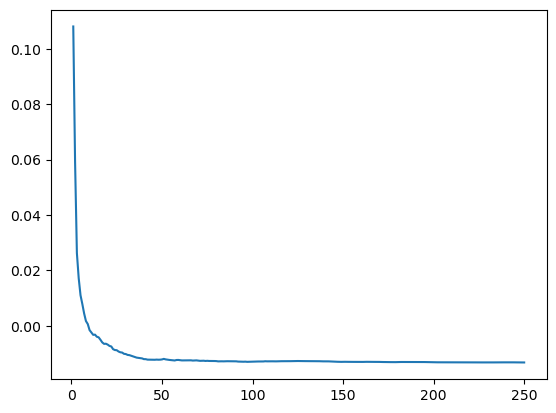

In [170]:
plt.plot(samples, kl_div)

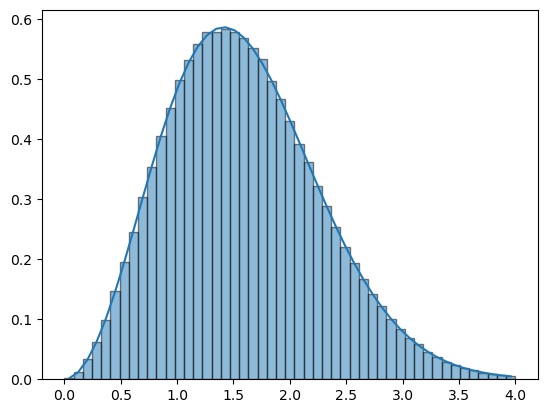

In [161]:
#plt.hist(velocities[50], bins=50, density=True)
plt.bar(bins[:-1], cumulative_average_histogram[-1], width=bins[1]-bins[0], align='edge', edgecolor='black', alpha=0.5)
plt.plot(bin_centers, v_dist_at_bins, label='Analytical')
#plt.plot(v, v_dist, 'k--')
plt.show()

In [181]:
cumulative_average_histogram.shape

(250, 49)

In [190]:
pdf_kde.shape

(50,)

In [192]:
samples

250

In [197]:
from scipy.stats import gaussian_kde

# Sample velocity data (replace this with your actual velocity data)

# Kernel Density Estimation with Gaussian kernel
kde = gaussian_kde(velocities[0].reshape(-1))

# Evaluate the estimated density on a grid
velocity_grid = np.linspace(0, 4, 50)
pdf_kde = np.zeros(50)


samples = len(velocities)
cumulative_kernel_density = np.zeros((samples, 50))
for i in range(1, samples+1):
    kde = gaussian_kde(velocities[i-1].reshape(-1))
    pdf_kde += kde.evaluate(velocity_grid)
    cumulative_kernel_density[i-1,:] = pdf_kde / i
#

In [198]:
cumulative_kernel_density.shape

(250, 50)

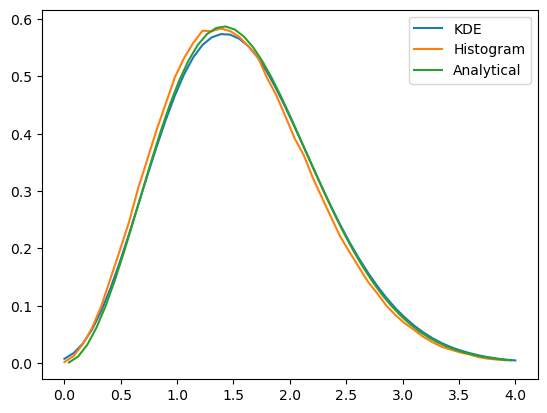

In [203]:
plt.plot(velocity_grid, cumulative_kernel_density[-1], label='KDE')
plt.plot(bins[:-1], cumulative_average_histogram[-1], label='Histogram')
plt.plot(bin_centers, v_dist_at_bins, label='Analytical')
plt.legend()
plt.show()